In [1]:
import sys
sys.path.append('./Modeling')
sys.path.append('./Data')

In [2]:
from regression import RegressionTransformer, get_parquet_data, randomforest_grid_search, model_eval, XGB_grid_search

In [3]:
# 전처리 완료 데이터 불러오기
csv_file_path = './Data/csv'

ride_df, alight_df = get_parquet_data(csv_file_path)

### 타겟 데이터의 왜도, 첨도 확인
- 타겟 데이터의 분포를 시각화로 확인
- 데이터의 분포가 정규 분포보다 뾰족한 형태를 지니고 있고, 오른쪽 꼬리가 길어 비대칭적이라는 사실을 알 수 있었음
- 분석 결과, 타겟 데이터를 보다 정규분포에 가깝게 만들어주고, 분산을 안정화 할 필요가 있다고 판단함
- 타겟 데이터에 **로그 변환**을 적용함

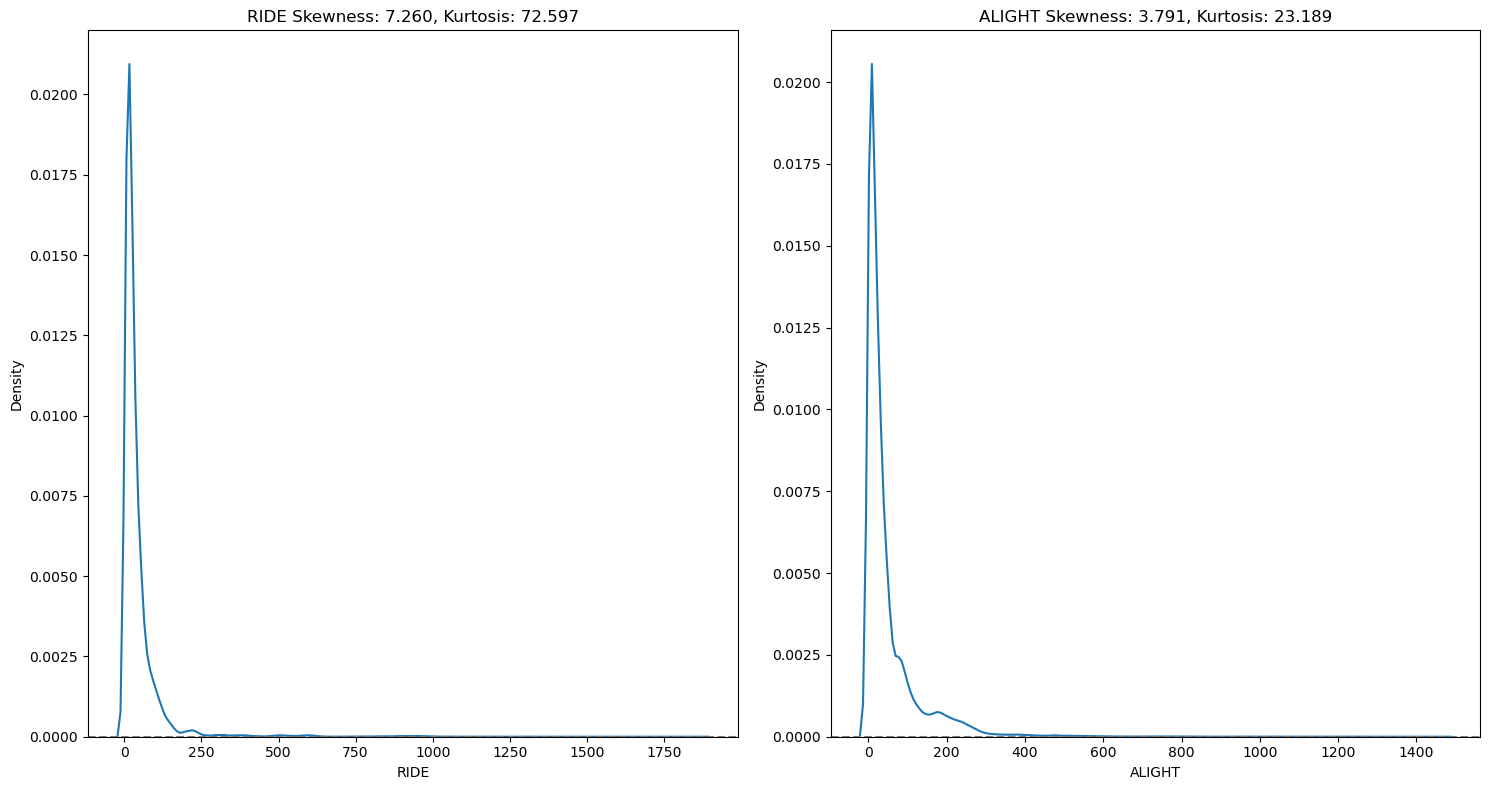

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

sns.kdeplot(ride_df['RIDE'], ax = ax1)
ax1.axhline(y=0, color='gray', linestyle='--')
ax1.set_title("RIDE Skewness: {:.3f}, Kurtosis: {:.3f}".format(ride_df['RIDE'].skew(), ride_df['RIDE'].kurt()), fontsize=12)

sns.kdeplot(alight_df['ALIGHT'], ax = ax2)
ax2.axhline(y=0, color='gray', linestyle='--')
ax2.set_title("ALIGHT Skewness: {:.3f}, Kurtosis: {:.3f}".format(alight_df['ALIGHT'].skew(), alight_df['ALIGHT'].kurt()),fontsize=12)

plt.tight_layout()

plt.show()

In [5]:
print("로그 변환 전 RIDE, ALIGHT의 왜도, 첨도")
print()
print("RIDE Skewness: {:.3f}".format(ride_df['RIDE'].skew()))
print("RIDE Kurtosis: {:.3f}".format(ride_df['RIDE'].kurt()))

print("ALIGHT Skewness: {:.3f}".format(alight_df['ALIGHT'].skew()))
print("ALIGHT Kurtosis: {:.3f}".format(alight_df['ALIGHT'].kurt()))

로그 변환 전 RIDE, ALIGHT의 왜도, 첨도

RIDE Skewness: 7.260
RIDE Kurtosis: 72.597
ALIGHT Skewness: 3.791
ALIGHT Kurtosis: 23.189


### 타겟 데이터 로그 스케일링, 피쳐 스케일링, 카테고리형 데이터 원핫인코딩
사이킷런 커스텀 변환기를 이용해 위 과정을 한번에 수행함

`RIDE, ALIGHT`
- 로그 스케일링 적용

`lon, lat, tmp, wsd, pcp`
- standard scaler를 적용함

`Hour`
- 데이터의 값이 6, 7, 8, 9로 이루어져 있는 카테고리형 데이터이기 때문에 원핫 인코딩을 적용

In [6]:
# 변환기 객체 생성
ride_transformer = RegressionTransformer(target = 'RIDE')
alight_transformer = RegressionTransformer(target = 'ALIGHT')

In [7]:
# 변환기 데이터프레임에 적용
ride_fit_df = ride_transformer.fit(ride_df)
ride_transform_df = ride_transformer.transform(ride_fit_df)

alight_fit_df = alight_transformer.fit(alight_df)
alight_transform_df = alight_transformer.transform(alight_df)

In [8]:
print("로그 변환 후 RIDE, ALIGHT의 왜도, 첨도")
print()
print("RIDE Skewness: {:.3f}".format(ride_fit_df['RIDE'].skew()))
print("RIDE Kurtosis: {:.3f}".format(ride_fit_df['RIDE'].kurt()))

print("ALIGHT Skewness: {:.3f}".format(alight_fit_df['ALIGHT'].skew()))
print("ALIGHT Kurtosis: {:.3f}".format(alight_fit_df['ALIGHT'].kurt()))

로그 변환 후 RIDE, ALIGHT의 왜도, 첨도

RIDE Skewness: 0.096
RIDE Kurtosis: 0.631
ALIGHT Skewness: -0.030
ALIGHT Kurtosis: -0.561


- 로그 스케일링 적용에 따른 타겟 데이터의 왜도, 첨도 변화

| 로그 변환 전  | 로그 변환 후  |
| ---           | ---           |
|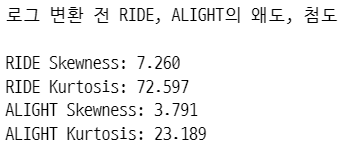 | 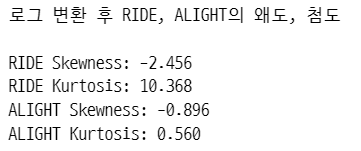 |

### 회귀 모델에 사용할 최종 데이터 세트
| ride_feature | alight_feature  |
|   ---   |     ---   |
| 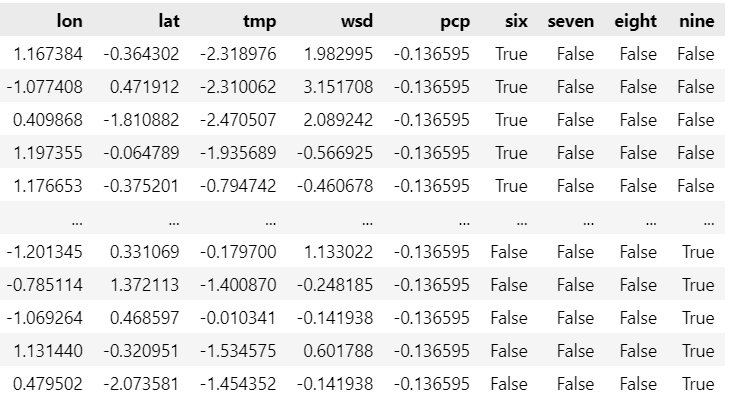 | 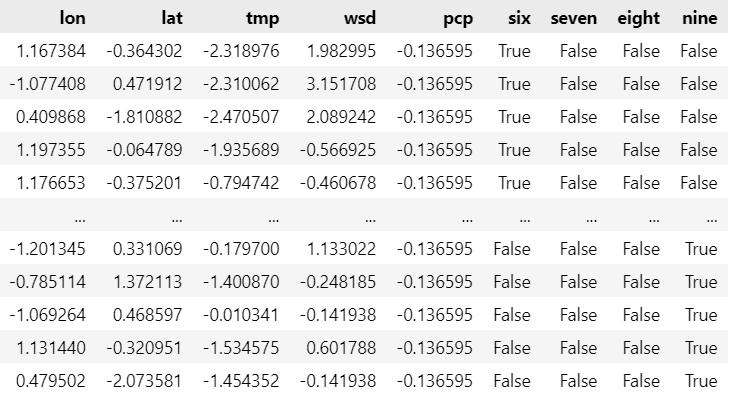 |


# 머신러닝을 이용한 승객 수 회귀 예측

### 훈련 데이터, 학습 데이터 분리

In [9]:
from sklearn.model_selection import train_test_split

ride_X_train, ride_X_test, ride_y_train, ride_y_test = train_test_split(
        ride_transform_df,
        ride_fit_df[['RIDE']],
        test_size=0.2,
        random_state=42
    )

alight_X_train, alight_X_test, alight_y_train, alight_y_test = train_test_split(
        alight_transform_df,
        alight_fit_df[['ALIGHT']],
        test_size=0.2,
        random_state=42
    )

### grid search를 이용해 최적 파라미터 구하기
- gird search를 통해 RandomForestRegression, XGBoost의 최적 하이퍼 파라미터 값을 구함
- 승차, 하차 데이터셋에 각각 적용 -> 총 4개의 결과값이 나옴

In [10]:
# RandomForest regression
rf_best_model_ride = randomforest_grid_search(ride_X_train, ride_y_train)
rf_best_model_alight = randomforest_grid_search(alight_X_train, alight_y_train)

c:\Users\eunbi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


: 

: 

In [ ]:
# XGBoost
xgb_best_model_ride = XGB_grid_search(ride_X_train, ride_y_train)
xgb_best_model_alight = XGB_grid_search(alight_X_train, alight_y_train)

In [39]:
# 최적 파라미터 값 확인
# rf_best_model_ride.get_params()
# rf_best_model_alight.get_params()
# xgb_best_model_ride.get_params()
# xgb_best_model_alight.get_params()

각 모델 별 최적 하이퍼 파라미터 값
- `rf_best_model_ride` :
        'n_estimators' : 200,
        'max_depth' : 15,
        'max_features': 0.8,
        'min_samples_leaf': 6
- `rf_best_model_alight` : 
        'n_estimators' : 200,
        'max_depth' : 15,
        'max_features': 0.8,
        'min_samples_leaf': 6
- `xgb_best_model_ride` : 
        "max_depth": 3,
        "learning_rate": 0.5,
        "n_estimators": 400,
        "subsample": 0.5,
        "colsample_bytree": 0.5
- `xgb_best_model_alight` : 
        "max_depth": 3,
        "learning_rate": 0.5,
        "n_estimators": 400,
        "subsample": 0.5,
        "colsample_bytree": 0.5

### 평가
- RandomForestRegression 모델과 XGB 모델의 승차, 하차 수 예측 결과를 비교함
- RMSE, R2 스코어를 사용
- 승차, 하차 각각의 데이터셋에서 더 좋은 성능을 가진 모델을 최종 모델로 선정

In [40]:
# model_eval(rf_best_model_ride, ride_X_train, ride_X_test, ride_y_train, ride_y_test)
# model_eval(rf_best_model_alight, alight_X_train, alight_X_test, alight_y_train, alight_y_test)
# model_eval(xgb_best_model_ride, ride_X_train, ride_X_test, ride_y_train, ride_y_test)
# model_eval(xgb_best_model_alight, alight_X_train, alight_X_test, alight_y_train, alight_y_test)

#### 모델 별 평가 점수

|               |   rf_best_model_ride  |   rf_best_model_alight    |   xgb_best_model_ride |   xgb_best_model_alight   |
| ---           |   ---                 |   ---                     |   ---                 |   ---                     |
| RMSE (train)  |   0.22127668209530796 |   0.2568383243411208      |   0.2398003518340028  |   0.2869251734533374      |
| R2 (train)    |   0.9550763779558472  |   0.9632430920496586      |   0.9472402055392115  |   0.9541270551676394      |
| RMSE (test)   |   0.24573817614634955 |   0.2816600982268587      |   0.24174866301315384 |   0.2893041962182526      |
| R2 (test)     |   0.9441735525425132  |   0.9555243497536028      |   0.9459715021919258  |   0.9530775025536661      |

- 근소한 차이로 RandomForestRegression 모델의 RMSE, R2 스코어 성능이 XGB보다 우수한 결과를 보임
- 최종 모델로 **RandomForest** 선정

## 최종 모델
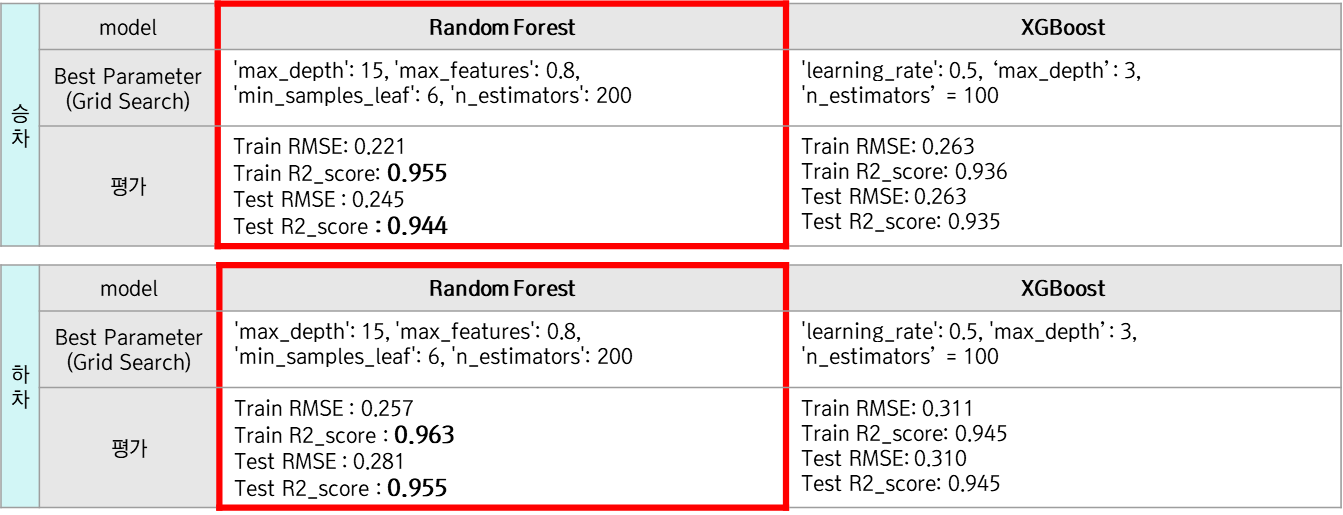

In [51]:
# 랜덤 포레스트의 최적 하이퍼 파라미터 모델 저장
import joblib
joblib.dump(rf_best_model_ride, 'rf_best_model_ride.pkl')
joblib.dump(rf_best_model_alight, 'rf_best_model_alight.pkl')

['rf_best_model_alight.pkl']

# 기후 데이터를 바탕으로 승객 수 예측

In [10]:
# 저장한 모델 불러오기
import joblib
ride_loaded_model = joblib.load(f'{csv_file_path}/rf_best_model_ride.pkl')
alight_loaded_model = joblib.load(f'{csv_file_path}/rf_best_model_alight.pkl')

c:\Users\eunbi\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\eunbi\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
# 기후 데이터 불러오기
import pandas as pd
waether = '0728_weather.csv'
weather_df = pd.read_csv(f'{csv_file_path}/{waether}', encoding = 'euc-kr')

# 기후 데이터를 학습 데이터 형식에 맞게 변환
pred_weather_transformer = RegressionTransformer(
    drop_cols = ['VEC', 'REH', 'X', 'Y', 'Date'], 
    rename_cols = {'raw_x':'lon', 'raw_y': 'lat', 'time': 'Hour', 'TMP': 'TMP'.lower(), 'WSD': 'WSD'.lower(), 'PCP': 'PCP'.lower()}
    )

In [16]:
pred_weather_df = pred_weather_transformer.fit(weather_df)
pred_weather_df = pred_weather_transformer.transform(pred_weather_df)

In [22]:
# 예측 데이터프레임 형태 확인
pred_weather_df

,lon,lat,tmp,wsd,pcp,six,seven,eight,nine
0,-1.247284,-1.102605,-1.624559,-0.579618,0.0,True,False,False,False
1,-1.247284,-1.102605,-0.375547,-1.050955,0.0,False,True,False,False
2,-1.247284,-1.102605,0.248958,0.363057,0.0,False,False,True,False
3,-1.247284,-1.102605,1.497970,1.777070,0.0,False,False,False,True
4,-1.169691,-1.065484,-1.624559,-0.579618,0.0,True,False,False,False
...,...,...,...,...,...,...,...,...,...
143,1.194433,1.510829,1.497970,1.305732,0.0,False,False,False,True
144,1.100553,1.625561,-1.000053,-1.050955,0.0,True,False,False,False
145,1.100553,1.625561,-0.375547,-0.579618,0.0,False,True,False,False
146,1.100553,1.625561,0.248958,-0.108280,0.0,False,False,True,False


In [18]:
ride_predictions = ride_loaded_model.predict(pred_weather_df)
alight_predictions = alight_loaded_model.predict(pred_weather_df)

c:\Users\eunbi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\eunbi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [19]:
import numpy as np

# 로그 역변환
ride_reversed_values = np.exp(ride_predictions)
alight_reversed_values = np.exp(alight_predictions)

print("역변환된 값 : ", ride_reversed_values)
print("역변환된 값 : ", alight_reversed_values)

역변환된 값 :  [  9.67165946  33.06068778  30.92885167  16.70586101  14.19646456
  39.73696262  45.2222871   26.23399054  14.37592341  49.98808532
  54.41145723  33.36906247   3.79985599  18.06450363  26.40024871
  17.10924985  20.58058185  90.93574215 123.59714839  92.84327518
  10.66980889  30.4760483   28.13418898  17.72857664  23.21870414
  91.57254889 147.80447915 103.13969348  23.08934571  99.96648017
 160.56318011 114.09671523  25.43984988  99.96648017 160.56318011
 114.09671523  25.27765142  98.72456016 158.24979628 111.90431831
  19.81434656  94.31224829 150.4623566  106.2945333   15.30315606
  86.10603123 118.842918    98.52415012  13.99070005  79.30547878
 112.29213618  89.62548377  10.84173683  65.84051254  85.15529617
  76.18226125  32.86241298 104.72865686 228.22779347 121.24008981
  32.86241298 104.72865686 228.22779347 121.24008981  32.86241298
 104.72865686 228.22779347 121.24008981  35.20404667 127.91464142
 300.50613997 141.5815654   35.0788792  127.91464142 300.50613997
